## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Comparing running time of traditional and the novel solvers for Kernel LDA

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import time
import matplotlib as mpl

##### Importing modules wtitten by the author

In [2]:
from KernelLinearDiscriminantAnalysis import KernelLinearDiscriminantAnalysis
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData

##### Defining a function for generating N samples of dimension dim

The data comes from a 2-class classification problem, where each class consists of 3 clusters.
Samples are drawn from Gaussian distributions with a specific covariance matrix.
Here, I have generated samples without **np.random.multivariate_normal** to speedup dataset generation.

In [3]:
def prepareDataset (N, dim):
    nClasses = 3
    nClusters = 1
    theta = np.pi / 4
    p3 = 1 / 3
    p2 = 1 / 3
    p1 = 1 / 3
    Ki = np.array([1, 1, 1], dtype=int)
    NKi = np.array([[p1 * N], [p2 * N], [p3 * N]], dtype=int)
    position = np.array([[[0, -1]], [[0, 0]], [[0, 1]]])

    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    means = np.zeros([nClasses, nClusters, dim])
    for i in range(nClasses):
        for j in range(nClusters):
            x, y = position[i, j]
            m = R @ np.sqrt(np.diag([1, 4])) @ np.array([x, y]) * 5 / np.sqrt(2)
            means[i, j, 0] = m[0]
            means[i, j, 1] = m[1]
            means[i, j, 2:] = 0

    scales = [0.25, 9]
    S = np.diag(scales)
    cov2 = R @ S @ R.T
    cov = np.zeros([dim, dim])
    cov[0:2, 0:2] = cov2
    for i in range(2, dim):
        cov[i, i] = scales[0]

    N = np.sum (NKi)
    XTrain = np.zeros ([N, dim])
    yTrain = np.zeros (N)
    idx = 0
    for i in range (nClasses):
        for j in range(nClusters):
            Xi_first = np.random.multivariate_normal (np.zeros(2), cov2, NKi[i, j])
            Xi_rest = np.random.randn(NKi[i, j], dim-2)
            Xi_rest *= scales[0]
            Xi = np.hstack([Xi_first,Xi_rest])
            Xi += means[i,j,:]            
            #Xi = np.random.multivariate_normal (means[i,j,:], cov, NKi[i, j])
            XTrain[idx:idx + NKi[i, j], :] = Xi
            yTrain[idx:idx + NKi[i, j]] = i
            idx += NKi[i, j]

    yTrain = np.array(yTrain, dtype='int')
    td = TrainingData(XTrain, yTrain)
    td.setSubclasses(Ki, NKi)
    return td, means

##### Depicting the distribution of data

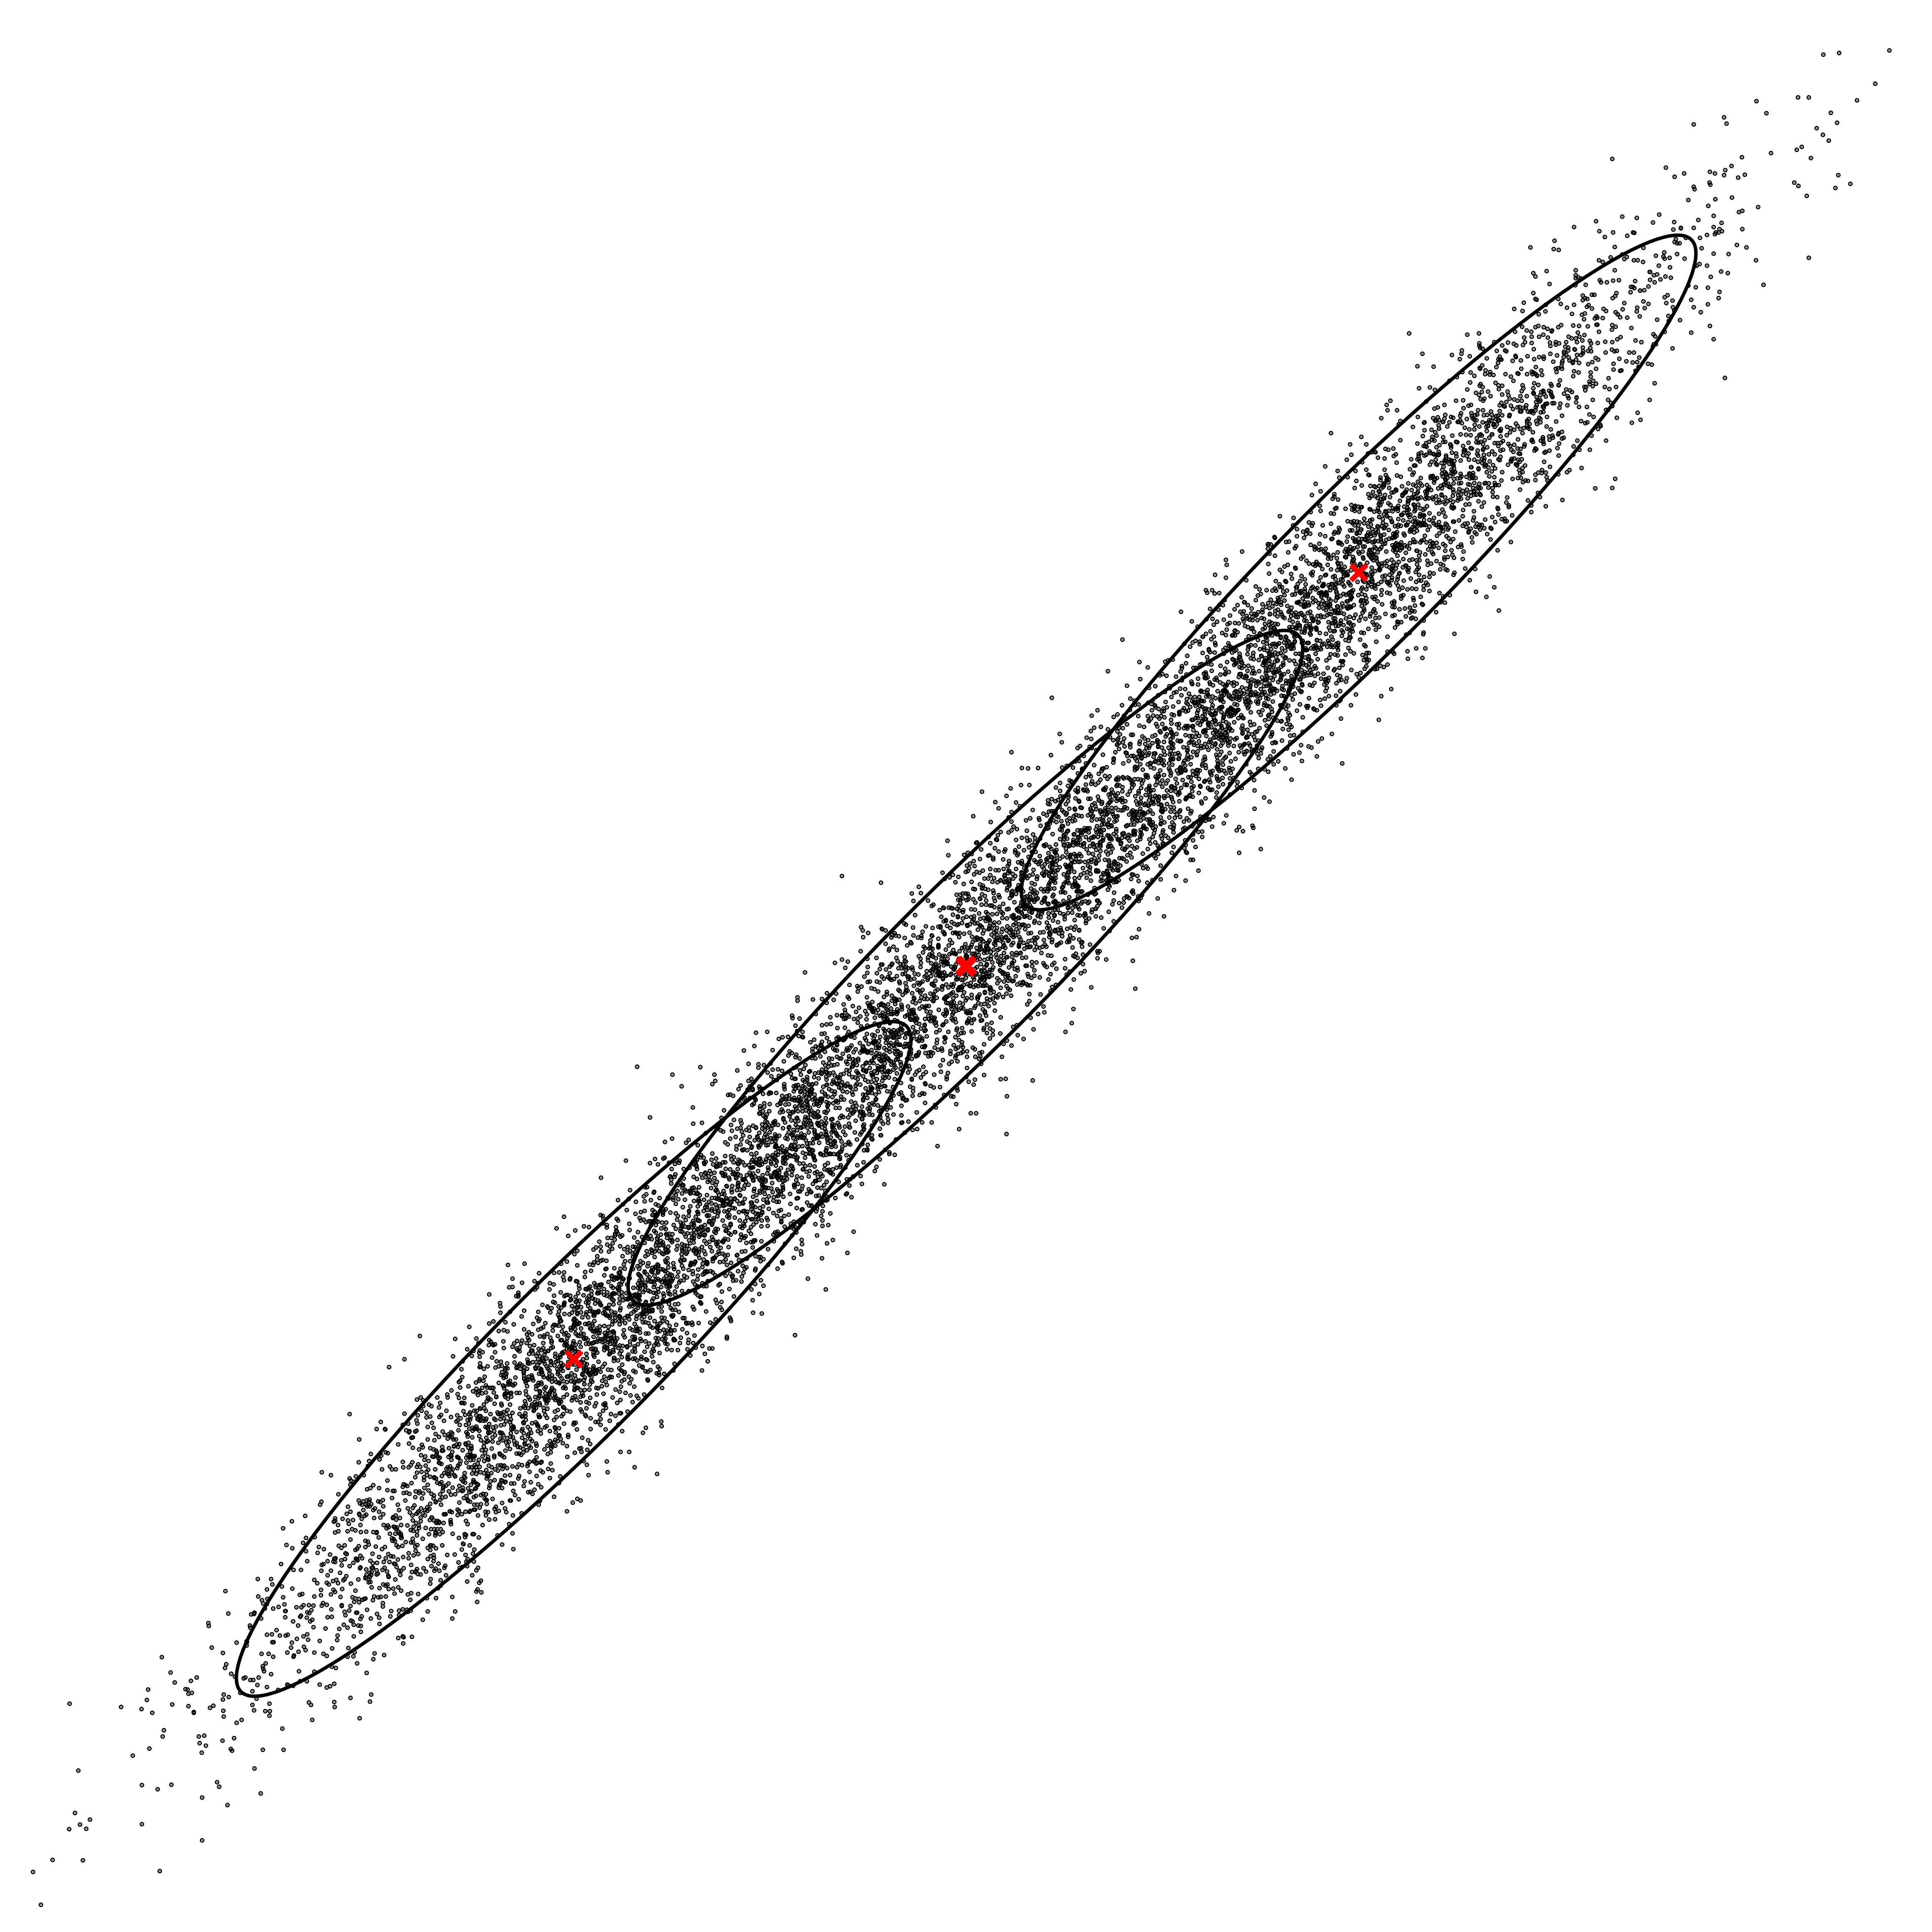

In [4]:
td, means = prepareDataset (10000, 128)
nClasses = 3
nClusters = 1
scales = [0.25, 9]
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
plt.figure(figsize=[10,10])
ax = plt.subplot(111, aspect='equal')
color_map = np.array(['blue', 'green', 'black'])
plt.scatter(td.X[:, 0], td.X[:, 1], s=0.1, c='black')
means_computed = td.subclassMeans.reshape([-1,2])
plt.scatter(means_computed[:,0], means_computed[:,1], s=20, marker='x', c='red')
s = 4
for i in range (nClasses):
    for j in range(nClusters):
        width = np.sqrt(scales[0]) * s
        height = np.sqrt(scales[1]) * s
        e = Ellipse(td.subclassMeans[i,j,:], width, height, -45, facecolor = 'none', edgecolor = 'k')
        ax.add_artist(e)
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.axis('off')
plt.show()

In [5]:
def kernelFunc(x,z):
    sigma2 = 10 * dim
    d2 = (x-z).T @ (x-z)
    #print (-d2/sigma2)
    return np.exp(-d2/sigma2)

##### Defining a function for measuring running time of a solver on a dataset.

In [6]:
def performExperiment(td, solver):
    klda = KernelLinearDiscriminantAnalysis(td, kernelFunc, 
                            solver, 0.0, 0.0001, approximateKernel = False)
    
    start = time.time()
    klda.fitFeatureExtractor()
    end = time.time()
    
    td_X_old = td.X
    td.X = klda.mapTrainingDataToExplicitFeatureMap()
    td.computeMeans()
    lda_feat_spc = LinearDiscriminantAnalysis(td, 'ghiasi_svd', 'none', 'Sb', 'St', 0.0, 0.0001)
    lda_feat_spc.fitFeatureExtractor()
    lda_feat_spc.model = klda.mapFeatureVectorsToExplicitFeatureMap()
    objective = lda_feat_spc.objective()
    td.X = td_X_old
    return end - start, objective

##### Performing experiments on N=100 samples with different dimensions

In [7]:
#Small Sample Size
N = 300
rep = 5
runtimeTable = np.zeros([2,16-10, 5])
objTable = np.zeros([2,16-10, 5])
for r in range (rep):
    for logDim in range(10,16):
        i = logDim - 10
        dim = 2 ** logDim
        td, means = prepareDataset (N, dim)

        solver = 'kfda'
        runTime, obj = performExperiment (td, solver)
        print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, obj))
        runtimeTable[0,i,r] = runTime
        objTable[0,i,r] = obj

        solver = 'ghiasi_kfda'
        runTime, obj = performExperiment (td, solver)
        print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, obj))
        runtimeTable[1,i,r] = runTime
        objTable[1,i,r] = obj


        print ('----------------------------------------------')

D:\research\FisherLDA\code.public.git\KernelLinearDiscriminantAnalysis.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i,:] = alpha[:,i] / np.sqrt(alpha[:,i].T @ self.centeredKerMat @ alpha[:,i])


For solver            kfda, N = 300, dim = 1024 runtime is 1.1184, objective = 2.0000
For solver     ghiasi_kfda, N = 300, dim = 1024 runtime is 0.8244, objective = 2.0000
----------------------------------------------
For solver            kfda, N = 300, dim = 2048 runtime is 1.0108, objective = 2.0000
For solver     ghiasi_kfda, N = 300, dim = 2048 runtime is 0.9396, objective = 2.0000
----------------------------------------------
For solver            kfda, N = 300, dim = 4096 runtime is 1.3880, objective = 2.0000
For solver     ghiasi_kfda, N = 300, dim = 4096 runtime is 1.1705, objective = 2.0000
----------------------------------------------
For solver            kfda, N = 300, dim = 8192 runtime is 1.9844, objective = 2.0000
For solver     ghiasi_kfda, N = 300, dim = 8192 runtime is 1.8583, objective = 2.0000
----------------------------------------------
For solver            kfda, N = 300, dim = 16384 runtime is 8.5898, objective = 2.0000
For solver     ghiasi_kfda, N = 300, 

In [10]:
for logDim in range(10,16):
    i = logDim - 10
    dim = 2 ** logDim
    print (dim, '&', '%0.4f'%np.mean(runtimeTable[0,i,:]), 
                '&', '%0.4f'%np.mean(objTable[0,i,:]), 
                '&', '%0.4f'%np.mean(runtimeTable[1,i,:]), 
                '&', '%0.4f'%np.mean(objTable[0,i,:]), '\\\\')

1024 & 0.9124 & 2.0000 & 0.7883 & 2.0000 \\
2048 & 1.0109 & 2.0000 & 0.9128 & 2.0000 \\
4096 & 1.3693 & 2.0000 & 1.2194 & 2.0000 \\
8192 & 2.0191 & 2.0000 & 1.9004 & 2.0000 \\
16384 & 8.7322 & 2.0000 & 8.5746 & 2.0000 \\
32768 & 11.2022 & 2.0000 & 11.1802 & 2.0000 \\


In [11]:
for logDim in range(10,16):
    i = logDim - 10
    dim = 2 ** logDim
    print (dim, '&',  '%0.4f'%np.mean(runtimeTable[0,i,:]), 
                '&', '%0.4f'%np.mean(runtimeTable[1,i,:]), '\\\\')

1024 & 0.9124 & 0.7883 \\
2048 & 1.0109 & 0.9128 \\
4096 & 1.3693 & 1.2194 \\
8192 & 2.0191 & 1.9004 \\
16384 & 8.7322 & 8.5746 \\
32768 & 11.2022 & 11.1802 \\


### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>